In this tutorial, we're gonna solve the time independent schroedinger equation for a non trivial potential system. 

In [1]:
import numpy as np
from matplotlib.pyplot import subplots
np.set_printoptions(precision=4, suppress=True)

from transit_chem.basis import HarmonicOscillator, EigenBasis
from transit_chem.operators import Hamiltonian, Overlap

## Using Arbitrary Potentials and a Basis

A good example to start is a symmetric double well potential. Let's create one. This also
demonstrates the ability of the library to work on **arbitrary potential functions**

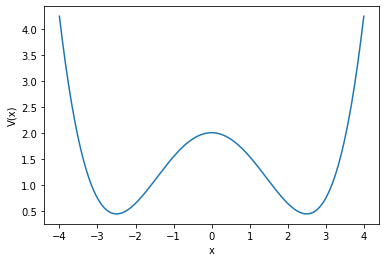

In [2]:
def potential(x):
    return -0.5*x**2 + 0.04 * x**4 + 2


fig, ax = subplots()
x = np.linspace(-4, 4, 300)
ax.plot(x, potential(x))
ax.set_xlabel("x")
_ = ax.set_ylabel("V(x)")

We can't solve this exactly, so we need to introduce a basis set. A reasonable choice would be to use a few
harmonic oscillator functions in each of the two wells. 

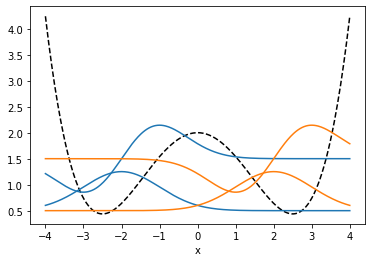

In [3]:
basis = [
    HarmonicOscillator(n=0, center=-2),
    HarmonicOscillator(n=1, center=-2), 
    HarmonicOscillator(n=0, center=2), 
    HarmonicOscillator(n=1, center=2),
]

fig, ax = subplots()
ax.plot(x, potential(x), "k--")
ax.set_xlabel("x")

ax.plot(x, basis[0](x) + basis[0].energy, color="C0")
ax.plot(x, basis[1](x) + basis[1].energy, color="C0")
ax.plot(x, basis[2](x) + basis[2].energy, color="C1")
_ = ax.plot(x, basis[3](x) + basis[3].energy, color="C1")

And that's basically it! We have a basis ready to go, and we've got our potential. Let's get the Hamiltonian!

## Getting the Hamiltonian and Overlap Matrices

In [4]:
H = Hamiltonian(potential).matrix(basis)
H

array([[ 1.15  ,  0.1697,  0.0005, -0.0275],
       [ 0.1697,  2.23  ,  0.0275, -0.1482],
       [ 0.0005,  0.0275,  1.15  , -0.1697],
       [-0.0275, -0.1482, -0.1697,  2.23  ]])

Normally, we'd diagonalize the hamiltonian and be done. However, we have a non-orthogonal basis, so we need
to account for that. We have to find an eigenbasis of **both the hamiltonian and overlap operators**. This means, we
need the overlap matrix, and we need to solve the **generalized eigenvalue problem**,  $\mathbf{HC} = \mathbf{ESC}$

In [5]:
S = Overlap().matrix(basis)
S

array([[ 1.    ,  0.    ,  0.0183, -0.0518],
       [ 0.    ,  1.    ,  0.0518, -0.1282],
       [ 0.0183,  0.0518,  1.    ,  0.    ],
       [-0.0518, -0.1282,  0.    ,  1.    ]])

As you can see, we're justified in needing to diagonalize the overlap matrix. The basis functions within each
well are indeed orthonormal, but the ones in separate wells are not. 

## The Eigenstates

Fortunately, it's easy to get the eigenstates
from the $\mathbf{H}$ and $\mathbf{S}$ matrices:

In [6]:
eig_basis = EigenBasis.from_basis(basis, H, S)
print(f"EigenEnergies = {eig_basis.energies}")
print(f"EigenVectors = \n{eig_basis.eigvecs}")

EigenEnergies = (1.112830250685375, 1.133287513512955, 2.114702264414521, 2.4540685273585483)
EigenVectors = 
[[ 0.6992  0.6967 -0.0577  0.1599]
 [-0.0869 -0.128  -0.6608  0.7476]
 [ 0.6992 -0.6967 -0.0577 -0.1599]
 [ 0.0869 -0.128   0.6608  0.7476]]


The eigen states can be represented as linear combinations of the original basis. 

$\phi(x)_j = \sum_i \chi_i \mathbf{C}_{ji}$

Where $\phi(x)_j$ is the $j$'th eigen state, $\chi_i$ is the $i$'th basis state, and $\mathbf{C}_{ji}$ is the $i, j$'th element
of the eigenvector matrix.

The eigenstates are available from `EigenBasis`

In [7]:
for i, state in enumerate(eig_basis.states):
    print(f"State {i}\n")
    print(state)
    print("-"*80)

State 0

0.6992 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.0869 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + 0.6992 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + 0.0869 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0)
--------------------------------------------------------------------------------
State 1

0.6967 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.1280 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + -0.6967 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + -0.1280 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0)
--------------------------------------------------------------------------------
State 2

-0.0577 * HarmonicOscillator(n=0, center=-2, mass=1.0, omega=1.0)
 + -0.6608 * HarmonicOscillator(n=1, center=-2, mass=1.0, omega=1.0)
 + -0.0577 * HarmonicOscillator(n=0, center=2, mass=1.0, omega=1.0)
 + 0.6608 * HarmonicOscillator(n=1, center=2, mass=1.0, omega=1.0)
---

And each of these eigenstates is available as a plain old function in one dimension

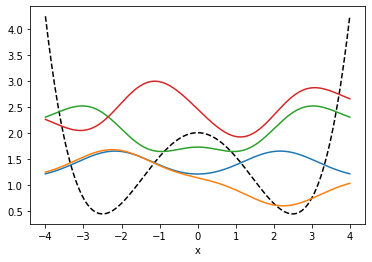

In [8]:
fig, ax = subplots()
ax.plot(x, potential(x), "k--")
ax.set_xlabel("x")

for state, e in zip(eig_basis.states, eig_basis.energies):
    ax.plot(x, state(x) + e)

There we have it! The solutions to the double well potential. In real systems we will want to use a larger basis set, 
but this suffices for demonstration purposes.


## Transforming from Original to Eigenbasis

Often it will be considerably easier to compute a quantity in the original basis. It
can be transformed into the eigenbasis by a similarity transform, 

$ \mathbf{X}_{eigen} =  \mathbf{C}^{-1} \mathbf{S}^{-1} \mathbf{X}_{original} \mathbf{C}$ 

Where $\mathbf{S}^{-1}$ is the overlap matrix and $ \mathbf{C}$ is the eigenvector matrix.
For example, we may want to validate that our eigenbasis diagonalizes the hamiltonian matrix:

In [9]:
eig_basis.transformed(H)

array([[ 1.1128,  0.    , -0.    ,  0.    ],
       [ 0.    ,  1.1333,  0.    ,  0.    ],
       [-0.    ,  0.    ,  2.1147,  0.    ],
       [-0.    ,  0.    ,  0.    ,  2.4541]])

We also might want to make sure that we've diagonalized the overlap matrix as well:

In [10]:
eig_basis.transformed(S)

array([[ 1., -0., -0., -0.],
       [-0.,  1., -0.,  0.],
       [ 0., -0.,  1., -0.],
       [ 0.,  0.,  0.,  1.]])

Remember, this transormation can be done to any matrix. And before we've shown
how we can transform any of our Operators into matrix form. So if we make an operator, we can
easily get its form in the eigen basis. To demonstrate, we can get the overlap in the $-x$ portion
of the potential with ease:

In [11]:
eig_basis.transformed(Overlap(-np.inf, 0).matrix(basis))

array([[ 0.5   ,  0.498 ,  0.    ,  0.034 ],
       [ 0.498 ,  0.5   ,  0.0404,  0.    ],
       [ 0.    ,  0.0404,  0.5   , -0.4792],
       [ 0.034 ,  0.    , -0.4792,  0.5   ]])

In [12]:
from transit_chem import __version__
print(__version__)

0.6.2
